# Autoregression Model Comparison

### Imports and Load data from 1965

In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.stats.diagnostic

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

warnings.filterwarnings("ignore")

# Memory control
physical_devices = tf.config.list_logical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Loading data
def load_dfs(save_dir='data_export'):

    g20_path = os.path.join(save_dir, 'g20_df_1965.pkl')
    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')

    try:
        g20_df = pd.read_pickle(g20_path)
        print(f"Successfully loaded g20 dataframe pickle file")
        lag_df = pd.read_pickle(lag_path)
        print(f"Successfully loaded time lagged g20 dataframe pickle file")

        return g20_df, lag_df

    except FileNotFoundError as e:
        print(f"Error in loading pickle files: {e}")

        try:
            g20_csv = g20_path.replace('.pkl', '.csv')
            lag_csv = lag_path.replace('.pkl', '.csv')

            g20_df = pd.read_csv(g20_csv)
            print(f"Successfully loaded g20 dataframe csv file")
            lag_df = pd.read_csv(lag_csv)
            print(f"Successfully loaded time lagged g20 dataframe csv file")

            return g20_df, lag_df

        except FileNotFoundError as e:
            print(f"Error in loading csv files: {e}")
            return None, None

In [2]:
g20_df, lag_df = load_dfs()

Successfully loaded g20 dataframe pickle file
Successfully loaded time lagged g20 dataframe pickle file


In [3]:
# Config
target_variables = ['co2', 'gdp', 'primary_energy_consumption']
n_steps_in = 5
n_steps_out = 3
g20_countries = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

### Utility Functions

In [4]:
# Optimised memory
def clear_memory():

    tf.keras.backend.clear_session()
    gc.collect()

    if len(tf.config.list_physical_devices('GPU')) > 0:
        tf.config.experimental.reset_memory_stats('GPU:0')

In [5]:
# Function for RMSE
def rmse(pred, actual):
    return np.sqrt(((pred - actual)**2).mean())

In [6]:
# Function for MASE
def mase(actual, pred, period=1):
    """
    MASE = MAE / naive_forecast_MAE(average magnitude of errors)
    """

    # MAE of prediction
    mae_forecast = mean_absolute_error(actual, pred)

    # MAE of naive forecast with previous period
    naive_forecast = actual[:-period] if period > 0 else actual[:-1]
    actual_for_naive = actual[period:] if period > 0 else actual[1:]

    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)

    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

In [7]:
# Checking stationary 
def check_stationary(data, alpha=0.05):

    result = adfuller(data)
    p_value = result[1]
    #print(f"ADF test p-value: {p_value:.4f}, Critical value: {alpha}")
    return p_value < alpha

In [8]:
# Cointegration using Engle-Granger test
def check_coint(y, X, alpha=0.05):
        
    _, p_value, _ = coint(y, X)
    #print(f"Coint test p-value: {p_value:.4f}")

    return p_value < alpha

In [9]:
# Inverse differencing
def inv_diff(forecast_diff, last_value):

    if last_value is None:
        return forecast_diff
    
    # Cumulative sum
    cum_values = [last_value]
    for diff_val in forecast_diff:
        cum_values.append(cum_values[-1] + diff_val)

    return np.array(cum_values[1:])

### Data Preperation and Functions

In [33]:
def get_target_info(target_var):

    scale_info = {
        'co2': {
            'unit': 'Million tonnes CO2'
        },
        'gdp': {
            'unit': 'USD'
        },
        'primary_energy_consumption': {
            'unit': 'Thousand TWh'
        }
    }

    return scale_info.get(target_var, {'unit': 'original'})

In [11]:
"""
VAR Checkpoints:
    Check stationary (Same as ARIMA)
    Check long-term stable relationship (statioanry) for two or more.
"""

# Preparing data for VAR
def prepare_var_data(X_train, target_col=0):

    orig_data = X_train.copy()
    processed_series = []

    # Test stationarity and diff & inverse diff
    diff_applied = []
    last_values = []

    for i in range(X_train.shape[1]):
        series = orig_data[:, i].copy()

        if check_stationary(series):
            #print(f"Variable {i} is stationary")
            processed_series.append(series)
            diff_applied.append(0)
            last_values.append(None)
        else:
            last_values.append(series[-1])
            diff_series = np.diff(series)
            processed_series.append(diff_series)
            diff_applied.append(1)
    
    min_length = min(len(series) for series in processed_series)
    trim_series = [series[-min_length:] for series in processed_series]
    trim_data = np.column_stack(trim_series)

    # Test cointegration with target
    target_series = trim_data[:, target_col]
    coint_vars = [target_col]

    for i in range(trim_data.shape[1]):
        if i != target_col:
            if check_coint(target_series, trim_data[:, i]):
                #print(f"Variable {i} is cointegrated with target")
                coint_vars.append(i)

    # Select coint vars
    selected_data = trim_data[:, coint_vars]
    selected_diff = [diff_applied[i] for i in coint_vars]
    selected_last = [last_values[i] for i in coint_vars]

    print(f"Selected vars: {coint_vars}")

    del orig_data
    gc.collect()

    return selected_data, coint_vars, selected_diff, selected_last

In [12]:
# Preparing Autoregression data
def prepare_ar_data(country, target_var, lag_df, n_steps_in=5):
    """
    n_steps_in=5 : current value + 4 lags
    """

    print(f"\nPreparing Autoregressive datafor {country}: {target_var}")

    # Country data from lag_df
    country_data = lag_df[lag_df['country'] == country].copy()
    country_data = country_data.sort_values('year')

    # Columns: target + 4 lags
    feature_cols = [target_var]
    for i in range(1, n_steps_in):
        lag_col = f"{target_var}_lag{i}"
        if lag_col in country_data.columns:
            feature_cols.append(lag_col)
        else:
            print(f"No {lag_col} for {country}")
        
    # Extract data and remove na
    data_subset = country_data[['year'] + feature_cols].copy()
    data_subset = data_subset.dropna()

    years = data_subset['year'].values

    # Unit information
    scale_info = get_target_info(target_var)

    features = []
    for col in feature_cols:
        features.append(data_subset[col].values)

    ar_data = np.column_stack(features)
    target_values = features[0]

    print(f"Features used: {feature_cols}")
    print(f"Data shape: {ar_data.shape}")
    print(f"Unit: {scale_info['unit']}")
    print(f"Target range: {np.min(target_values):.2f} - {np.max(target_values):.2f}")

    return ar_data, years, target_values, feature_cols, scale_info

In [13]:
# Create sequences to make it 3 steps out
def create_seq_for_pred(ar_data, n_steps_out=3):
    """
    [t-4, t-3, t-2, t-1, t] -> [t+1, t+2, t+3]
    """

    X, y = [], []
    
    for i in range(len(ar_data) - n_steps_out):
        # [t, t-1, t-2, t-3, t-4]: Shape (5,)
        X_seq = ar_data[i]
        
        # [t+1, t+2, t+3]
        y_seq = []
        for j in range(1, n_steps_out + 1):

            if i + j < len(ar_data):
                # First column is the target
                y_seq.append(ar_data[i + j, 0])
            else:
                break
            
        if len(y_seq) == n_steps_out:
            X.append(X_seq)
            y.append(y_seq)

    # Shape (n_samples, 5)
    X = np.array(X)
    # Shape (n_samples, 3)
    y = np.array(y)

    return X, y

In [14]:
# Preparing data for DL to handle 3D inputs and scaling
def prepare_dl_data(X_train, y_train, X_val, y_val, X_test, y_test):
    
    # Shape (n_samples, 5, 1)

    # StandardScaler is better for future extrapolation wrt time series (2D)
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Fit training data (n_samples, 5) for X, (n_samples, 3) for y
    X_scaler.fit(X_train)
    y_scaler.fit(y_train)

    X_train_scaled = X_scaler.transform(X_train)
    y_train_scaled = y_scaler.transform(y_train)
    X_val_scaled = X_scaler.transform(X_val)
    y_val_scaled = y_scaler.transform(y_val)
    X_test_scaled = X_scaler.transform(X_test)

    # Reshape for input (n_samples, timesteps, n_features)
    X_train_dl = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    X_val_dl = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
    X_test_dl = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

    print(f"Scaling range Train: {y_train_scaled.min():.4f} - {y_train_scaled.max():.4f}")

    return X_train_dl, y_train_scaled, X_val_dl, y_val_scaled, X_test_dl, y_scaler

### Constructing Models

In [15]:
# Tuning ARIMA - AIC criterion
def tune_arima_params(data, max_p=4, max_d=2, max_q=3):
    """
    p (autoregressive order): num of lag obs to include
    d (differencing degree): num of time data different to make it stationary
    q (moving avg order): size of moving avg window
    Lower AIC -> better model fit
    """

    best_aic = np.inf
    best_params = None
    best_model = None

    # Testing stationarity
    result = adfuller(data)
    max_d = 1 if result[1] <= 0.05 else 2

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    fitted_model = model.fit()
                    aic = fitted_model.aic

                    if aic < best_aic:
                        best_aic = aic
                        best_params = (p, d, q)
                        best_model = fitted_model
                    
                except:
                    continue
    
    print(f"Best ARIMA params: {best_params}, AIC: {best_aic:.2f}")

    return best_model, best_params, best_aic

In [16]:
# Tuning VAR 
# -> it might cause overfitting since there are too less tranining samples compared to the number of features
def tune_var_params(data, max_lags=4):
    """
    Each variable is modeled as linear of past values of itself (other variables but not for this data)
    lag_order -> num of lag periods to include
    using AIC to select optimal lag order.
    """

    var_df = pd.DataFrame(data, columns=[f'var{i}' for i in range(data.shape[1])])
    model = VAR(var_df)

    obs_lag = len(var_df) // (data.shape[1] * 4)
    eff_max_lags = min(max_lags, obs_lag)
    eff_max_lags = max(1, eff_max_lags)

    lag_result = model.select_order(maxlags=eff_max_lags)
    best_lag = lag_result.selected_orders['aic']
    print(f"Best lag order: {best_lag}")

    fitted_model = model.fit(best_lag)

    del var_df
    gc.collect()
    
    return fitted_model, best_lag

In [17]:
# Autoregressive vanilla LSTM
def build_ar_lstm(input_shape, hidden=16):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape,
             kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

In [18]:
# Autoregressive Bidirectional LSTM
def build_ar_bilstm(input_shape, hidden=8):
    model = Sequential([
        Bidirectional(LSTM(hidden, activation='relu', kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)),
                       input_shape=input_shape),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

In [19]:
# Autoregressive Encoder-Decoder LSTM
def build_ar_edlstm(input_shape, hidden=8):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape,
             kernel_regularizer=l2(0.001)),
        RepeatVector(n_steps_out),
        LSTM(hidden, activation='relu', return_sequences=True,
             kernel_regularizer=l2(0.001)),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

In [20]:
# Autoregressive CNN
def build_ar_cnn(input_shape, filters=32, hidden=8):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=input_shape, padding='same',
               kernel_regularizer=l2(0.001)),
        Flatten(),
        Dense(hidden, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

### Model training and evaluation functions

In [21]:
# Training ARIMA
def train_arima_model(X_train, y_train, X_test, y_test):

    try:
        # Using first column of the target (1D)
        target_train = X_train[:, 0]

        model, params, aic = tune_arima_params(target_train)

        preds = []

        # Forecasting len(y_test) steps
        for i in range(len(y_test)):
            try:
                # Forecasting 1 step
                forecast_result = model.forecast(steps=1)
                # Check if its not a sequence (array, list, pandas Series) 
                pred_value = forecast_result[0] if hasattr(forecast_result, '__len__') else forecast_result
                preds.append(pred_value)

                # Update the model with actual for the next pred
                if i < len(y_test) - 1:
                    actual_next = y_test[i, 0]
                    new_data = np.append(target_train, actual_next)
                    model = ARIMA(new_data, order=params).fit()
                    target_train = new_data

            except Exception as e:
                print(f"ARIMA pred step {i} failed {e}")
                preds.append(preds[-1] if preds else 0)

        preds = np.array(preds)
        actual_test = y_test[:, 0]

        rmse_score = rmse(preds, actual_test)
        mase_score = mase(actual_test, preds)

        return preds, rmse_score, mase_score

    except Exception as e:
        print(f"ARIMA training failed {e}")

        return None, None, None

In [22]:
# Training VAR
# This is actually a bad model since inputs are all time lags of the target so perfect correlation
def train_var_model(X_train, y_train, X_test, y_test):

    try:
        var_data, selected_vars, diff_orders, last_values = prepare_var_data(X_train)

        fitted_model, best_lag = tune_var_params(var_data)

        # Forecast input
        if len(var_data) >= best_lag:
            forecast_input = var_data[-best_lag:]
        else:
            forecast_input = var_data

        # Forecast
        n_steps = len(y_test)
        forecast_result = fitted_model.forecast(forecast_input, steps=n_steps)

        # Target preds
        if len(forecast_result.shape) == 1:
            preds_diff = forecast_result
        else:
            preds_diff = forecast_result[:, 0]

        # Inverse differencing if needed
        target_diff_order = diff_orders[0]
        target_last_value = last_values[0]

        if target_diff_order > 0:
            preds = inv_diff(preds_diff, target_last_value)
            #print(f"Final predictions range: {preds.min():.2f} - {preds.max():.2f}")
        else:
            preds = preds_diff

        # Metrics
        actual = y_test[:, 0]
        min_length = min(len(preds), len(actual))
        preds = preds[:min_length]
        actual = actual[:min_length]

        #print(f"Actual value range: {actual.min():.2f} - {actual.max():.2f}")

        rmse_score = rmse(preds, actual)
        mase_score = mase(actual, preds)

        print(f"VAR - RMSE: {rmse_score:.4f}, MASE: {mase_score:.4f}")

        return preds, rmse_score, mase_score

    except Exception as e:
        print(f"VAR training failed {e}")
        return None, None, None

In [23]:
# Training DL models
def train_dl_model(model_build, X_train, y_train, X_val, y_val, X_test, y_test, model_name):

    try:
        # Prep data for dl
        X_train_dl, y_train_scaled, X_val_dl, y_val_scaled, X_test_dl, y_scaler = prepare_dl_data(
            X_train, y_train, X_val, y_val, X_test, y_test
        )

        # Build model
        # (Steps, n_features)
        input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])
        model = model_build(input_shape)

        early_stopping = EarlyStopping(
            monitor='val_loss', patience=25, restore_best_weights=True, min_delta=0.01
            )   # patience=15 since it a small dataset for each feature for each country
                # min_delta=0.01 for less striction

        # Calculate batch_size
        batch_size = min(8, len(X_train_dl))

        # Train model
        history = model.fit(
            X_train_dl, y_train_scaled,
            validation_data=(X_val_dl, y_val_scaled),
            epochs=100,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )

        # Predict
        preds_scaled = model.predict(X_test_dl, verbose=0)

        # Handling ED-LSTM 3D output (batch, steps, 1)
        if len(preds_scaled.shape) == 3:
            preds_scaled = preds_scaled.reshape(preds_scaled.shape[0], preds_scaled.shape[1])

        preds = y_scaler.inverse_transform(preds_scaled)

        print(f"Prediction range: {preds.min():.1f} to {preds.max():.1f}")
        print(f"Actual test range: {y_test.min():.1f} to {y_test.max():.1f}")

        # First step preds
        pred_first = preds[:, 0]
        actual_first = y_test[:, 0]

        # Metrics
        rmse_score = rmse(pred_first, actual_first)
        mase_score = mase(actual_first, pred_first)

        # Memory
        del model, history, X_train_dl, y_train_scaled, X_val_dl, y_val_scaled, X_test_dl
        clear_memory()

        return pred_first, rmse_score, mase_score

    except Exception as e:
        print(f"{model_name} training failed {e}")
        clear_memory()
        return None, None, None

### Testing Frameworks

In [24]:
def analyse_data(country, target_var, lag_df):

    ar_data, years, target_values, feature_cols, scale_info = prepare_ar_data(
        country, target_var, lag_df, n_steps_in
    )

    print(f"Data Range: {np.min(target_values):.2f} - {np.max(target_values):.2f}")
    print(f"Mean: {np.mean(target_values):.2f}")
    print(f"Std: {np.std(target_values):.2f}")

    changes = np.diff(target_values)
    print(f"Avg yearly change: {np.mean(changes):.1f}")
    print(f"Max yearly change: {np.max(np.abs(changes)):.1f}")
    
    return {
        'range': np.max(target_values) - np.min(target_values),
        'mean': np.mean(target_values),
        'growth_factor': target_values[-1]/target_values[0] if target_values[0] != 0 else np.inf,
        'max_change': np.max(np.abs(changes)),
        'data_points': len(target_values),
        'years_range': (years[0], years[-1])
    }

In [25]:
# Test country
def test_country_target(country, target_var, lag_df):

    print(f"Testing {country}: {target_var}")

    data_stats = analyse_data(country, target_var, lag_df)

    # Prepare data
    ar_data, years, target_values, feature_cols, scale_info = prepare_ar_data(
        country, target_var, lag_df, n_steps_in=5
    )

    # Seq for pred
    X, y = create_seq_for_pred(ar_data, n_steps_out)

    """
    feature_df = pd.DataFrame(ar_data, columns=feature_cols)

    try:    
        train, val, test, X_train, y_train, X_val, y_val, X_test, y_test = shuffled_test_train_val(
                n_steps_in, n_steps_out, feature_df, test_size=0.2, val_size=0.1
            )
    except Exception as e:
        print(f"Error with shuffled_test_train_val {e}")
    """
    
    # Time series seq split
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]

    # Test years for plots
    test_start_idx = train_size + val_size
    test_years = years[test_start_idx:test_start_idx + len(X_test)]

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    results = {}

    # Testing models
    model_configs = [
        ('ARIMA', lambda: train_arima_model(X_train, y_train, X_test, y_test)),
        ('VAR', lambda: train_var_model(X_train, y_train, X_test, y_test)),
        ('LSTM', lambda: train_dl_model(build_ar_lstm, X_train, y_train, X_val, y_val, X_test, y_test, 'LSTM')),
        ('Bi-LSTM', lambda: train_dl_model(build_ar_bilstm, X_train, y_train, X_val, y_val, X_test, y_test, 'Bi-LSTM')),
        ('ED-LSTM', lambda: train_dl_model(build_ar_edlstm, X_train, y_train, X_val, y_val, X_test, y_test, 'ED-LSTM')),
        ('CNN', lambda: train_dl_model(build_ar_cnn, X_train, y_train, X_val, y_val, X_test, y_test, 'CNN'))
    ]

    for model_name, train_func in model_configs:
        print(f"\nTraining {model_name}")

        preds, rmse_score, mase_score = train_func()

        if preds is not None:
            print(f"{model_name} - RMSE:{rmse_score:.4f}, MASE:{mase_score:.4f}")

            results[model_name] = {
                'predictions': preds,
                'rmse': rmse_score,
                'mase': mase_score,
                'actual': y_test[:, 0],
                'test_years': test_years,
                'scale_info': scale_info
            }
        else:
            print(f"{model_name} failed")

        clear_memory()

    return results

In [26]:
country = 'United States'
target_var = 'co2'
test_country_target(country, target_var, lag_df)

Testing United States: co2

Preparing Autoregressive datafor United States: co2
Features used: ['co2', 'co2_lag1', 'co2_lag2', 'co2_lag3', 'co2_lag4']
Data shape: (59, 5)
Unit: Million tonnes CO2
Target range: 3399.55 - 6132.18
Data Range: 3399.55 - 6132.18
Mean: 5091.87
Std: 650.04
Avg yearly change: 26.1
Max yearly change: 547.5

Preparing Autoregressive datafor United States: co2
Features used: ['co2', 'co2_lag1', 'co2_lag2', 'co2_lag3', 'co2_lag4']
Data shape: (59, 5)
Unit: Million tonnes CO2
Target range: 3399.55 - 6132.18
Train: 39, Val: 8, Test: 9

Training ARIMA
Best ARIMA params: (0, 2, 2), AIC: 472.78
ARIMA - RMSE:350.5722, MASE:1.5457


Training VAR
Selected vars: [0, 1, 2, 3, 4]
Best lag order: 1
VAR - RMSE: 1114.4355, MASE: 5.5370
VAR - RMSE:1114.4355, MASE:5.5370

Training LSTM
Scaling range Train: -2.1623 - 1.7896
Prediction range: 5112.4 to 5809.6
Actual test range: 4714.6 to 5528.7
LSTM - RMSE:359.6297, MASE:1.7037

Training Bi-LSTM
Scaling range Train: -2.1623 - 1.789

{'ARIMA': {'predictions': array([6069.94348918, 5196.38483912, 5593.37152913, 5316.68598825,
         5176.89795913, 5152.32044643, 5402.19290002, 5222.78245029,
         4515.67496635]),
  'rmse': np.float64(350.57215344821986),
  'mase': np.float64(1.5456812675940859),
  'actual': array([5480.157, 5528.681, 5376.473, 5252.932, 5212.162, 5377.797,
         5262.145, 4714.628, 5032.213]),
  'test_years': array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]),
  'scale_info': {'unit': 'Million tonnes CO2'}},
 'VAR': {'predictions': array([6036.74731982, 6087.73069256, 6165.94138558, 6231.39523472,
         6292.80440469, 6361.6847755 , 6428.37640855, 6491.35308182,
         6556.03977524]),
  'rmse': np.float64(1114.4355269510968),
  'mase': np.float64(5.536991896706228),
  'actual': array([5480.157, 5528.681, 5376.473, 5252.932, 5212.162, 5377.797,
         5262.145, 4714.628, 5032.213]),
  'test_years': array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]),
  'scale_inf

### Running Tests

In [27]:
def run_all_tests():

    all_results = defaultdict(lambda: defaultdict(dict))
    summary_stats = defaultdict(lambda: defaultdict(list))

    for target_var in target_variables:
        print(f"\nTesting target: {target_var.upper()}")

        for country in g20_countries:
            country_results = test_country_target(country, target_var, lag_df)

            all_results[target_var][country] = country_results

            for model_name, metrics in country_results.items():
                summary_stats[target_var][model_name].append({
                    'country': country,
                    'rmse': metrics['rmse'],
                    'mase': metrics['mase'],
                    'scale_info': metrics['scale_info']
                })
                
        clear_memory()

    return all_results, summary_stats

In [28]:
all_results, summary_stats = run_all_tests()


Testing target: CO2
Testing United States: co2

Preparing Autoregressive datafor United States: co2
Features used: ['co2', 'co2_lag1', 'co2_lag2', 'co2_lag3', 'co2_lag4']
Data shape: (59, 5)
Unit: Million tonnes CO2
Target range: 3399.55 - 6132.18
Data Range: 3399.55 - 6132.18
Mean: 5091.87
Std: 650.04
Avg yearly change: 26.1
Max yearly change: 547.5

Preparing Autoregressive datafor United States: co2
Features used: ['co2', 'co2_lag1', 'co2_lag2', 'co2_lag3', 'co2_lag4']
Data shape: (59, 5)
Unit: Million tonnes CO2
Target range: 3399.55 - 6132.18
Train: 39, Val: 8, Test: 9

Training ARIMA
Best ARIMA params: (0, 2, 2), AIC: 472.78
ARIMA - RMSE:350.5722, MASE:1.5457

Training VAR
Selected vars: [0, 1, 2, 3, 4]
Best lag order: 1
VAR - RMSE: 1114.4355, MASE: 5.5370
VAR - RMSE:1114.4355, MASE:5.5370

Training LSTM
Scaling range Train: -2.1623 - 1.7896
Prediction range: 5231.5 to 5486.6
Actual test range: 4714.6 to 5528.7
LSTM - RMSE:236.3537, MASE:0.8421

Training Bi-LSTM
Scaling range Tr

### Results

In [29]:
def analyse_results(summary_stats, save_dir='data_export'):
    
    print("\nSummary Statistics")
    
    # Create save directory
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Directory created")

    summary_df_list = []
    
    for target_var in target_variables:
        scale_info = get_target_info(target_var)
        print(f"\n{target_var.upper()} Results (Unit: {scale_info['unit']})")
        
        for model_name in ['ARIMA', 'VAR', 'LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN']:
            if model_name in summary_stats[target_var] and summary_stats[target_var][model_name]:

                stats = summary_stats[target_var][model_name]
                rmse_values = [s['rmse'] for s in stats]
                mase_values = [s['mase'] for s in stats]
                
                summary_df_list.append({
                    'Target': target_var,
                    'Model': model_name,
                    'Unit': scale_info['unit'],
                    'Countries': len(stats),
                    'Avg_RMSE': np.mean(rmse_values),
                    'Min_RMSE': np.min(rmse_values),
                    'Max_RMSE': np.max(rmse_values),
                    'Avg_MASE': np.mean(mase_values),
                    'Min_MASE': np.min(mase_values),
                    'Max_MASE': np.max(mase_values)
                })
                
                print(f"{model_name:>10}: Countries={len(stats):>2}, "
                      f"RMSE: {np.mean(rmse_values):>8.3f} [{np.min(rmse_values):>8.3f}-{np.max(rmse_values):>8.3f}], "
                      f"MASE: {np.mean(mase_values):>6.2f} [{np.min(mase_values):>6.2f}-{np.max(mase_values):>6.2f}]")
            else:
                print(f"{model_name:>10}: No results")
    
    summary_df = pd.DataFrame(summary_df_list)

    # Save as csv
    summary_csv_path = os.path.join(save_dir, 'ar_summay.csv')
    summary_df.to_csv(summary_csv_path, index=False)

    return summary_df

In [30]:
summary_df = analyse_results(summary_stats)


Summary Statistics

CO2 Results (Unit: Million tonnes CO2)
     ARIMA: Countries=19, RMSE:  205.279 [  13.555-2243.321], MASE:   1.94 [  0.81-  4.87]
       VAR: Countries=18, RMSE:  234.966 [  19.586-1197.023], MASE:   5.51 [  1.47-  9.64]
      LSTM: Countries=19, RMSE:  345.337 [  29.980-3929.886], MASE:   5.37 [  0.84- 16.09]
   Bi-LSTM: Countries=19, RMSE:  517.031 [  45.016-6474.846], MASE:   6.19 [  0.73- 26.53]
   ED-LSTM: Countries=19, RMSE:  332.156 [  20.700-3733.723], MASE:   5.67 [  1.17- 15.26]
       CNN: Countries=19, RMSE:  164.332 [  10.686-1649.789], MASE:   2.73 [  0.61- 15.01]

GDP Results (Unit: USD)
     ARIMA: Countries=19, RMSE: 699303548663.563 [89365322003.826-6020789017639.172], MASE:   3.28 [  1.17-  7.75]
       VAR: Countries=16, RMSE: 940621041220.145 [113971274514.709-4513266144851.535], MASE:  10.19 [  1.83- 24.72]
      LSTM: Countries=19, RMSE: 1270186672404.300 [88967245697.806-6943600236994.996], MASE:  10.53 [  1.77- 50.74]
   Bi-LSTM: Countries=

### Plot models

In [35]:
def plot_model_comparisons(all_results, target_var, country, save_plots=True, save_dir='data_export'):
    
    country_results = all_results[target_var][country]
    
    # Calculate subplot layout
    n_models = len(country_results)
    cols = min(3, n_models)
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    model_names = list(country_results.keys())
    
    for i, model_name in enumerate(model_names):
        ax = axes[i]
        results = country_results[model_name]
        actual = results['actual']
        preds = results['predictions']
        test_years = results['test_years']
        scale_info = results['scale_info']
        
        ax.plot(test_years, actual, label='Actual', color='blue', alpha=0.7, linewidth=2, marker='o', markersize=4)
        ax.plot(test_years, preds, label='Prediction', color='red', alpha=0.7, linewidth=2, marker='s', markersize=3)
        
        # In scaled units
        title = f'{model_name}\n'
        title += f'RMSE: {results["rmse"]:.2f} ({scale_info["unit"]})\n'
        title += f'MASE: {results["mase"]:.2f}'
        
        ax.set_title(title, fontsize=10)
        ax.legend(fontsize=8)
        ax.set_xlabel('Year', fontsize=9)
        ax.set_ylabel(f'{target_var}\n ({scale_info["unit"]})', fontsize=9)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
    
    # Hide extra plots
    for i in range(len(model_names), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'{country} - {target_var} - Model Comparison for test set', fontsize=14)
    plt.tight_layout()
    
    # Save plots
    if save_plots:
        plots_dir = os.path.join(save_dir, 'plots')
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        
        filename = os.path.join(plots_dir, f'{country}_{target_var}_comparison.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved: {filename}")
    
    plt.show()

Plotting United States - co2
Plot saved: data_export\plots\United States_co2_comparison.png


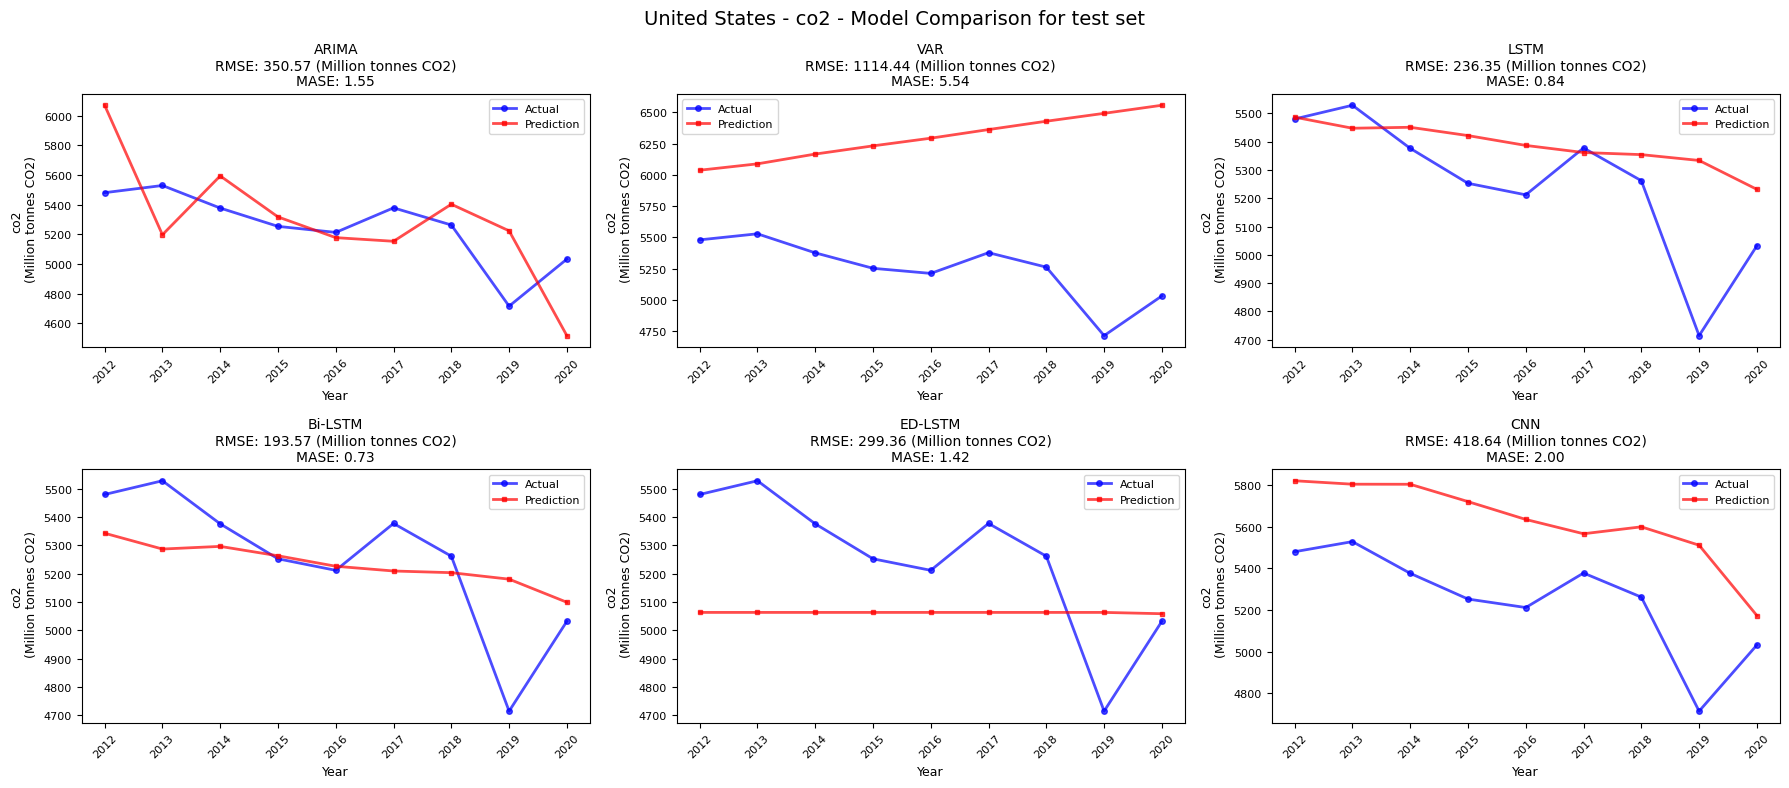

Plotting China - co2
Plot saved: data_export\plots\China_co2_comparison.png


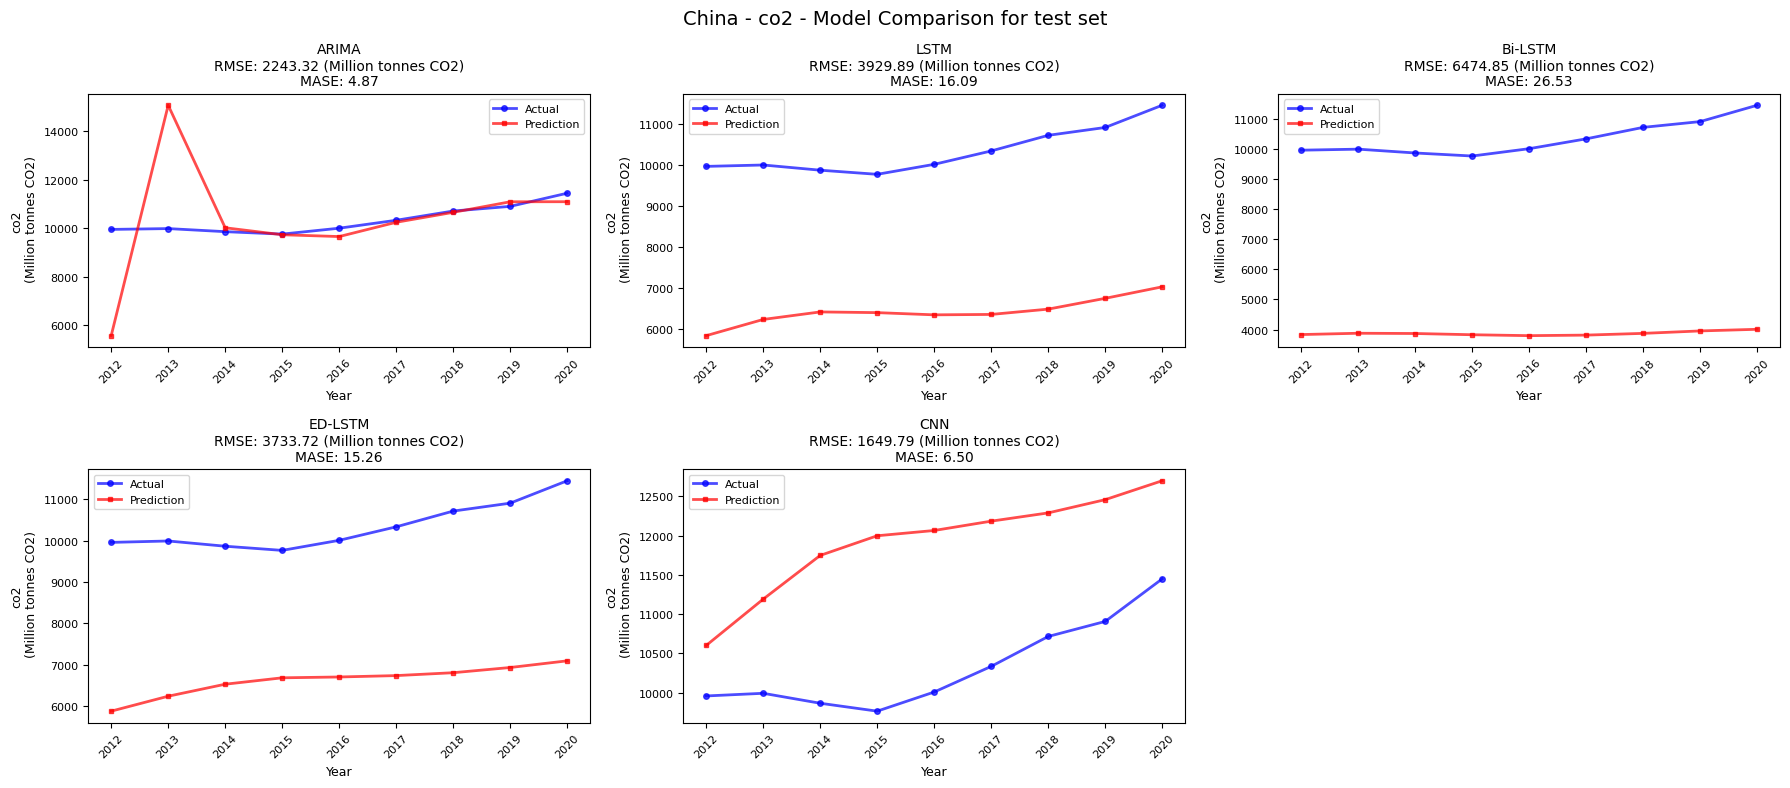

Plotting Germany - co2
Plot saved: data_export\plots\Germany_co2_comparison.png


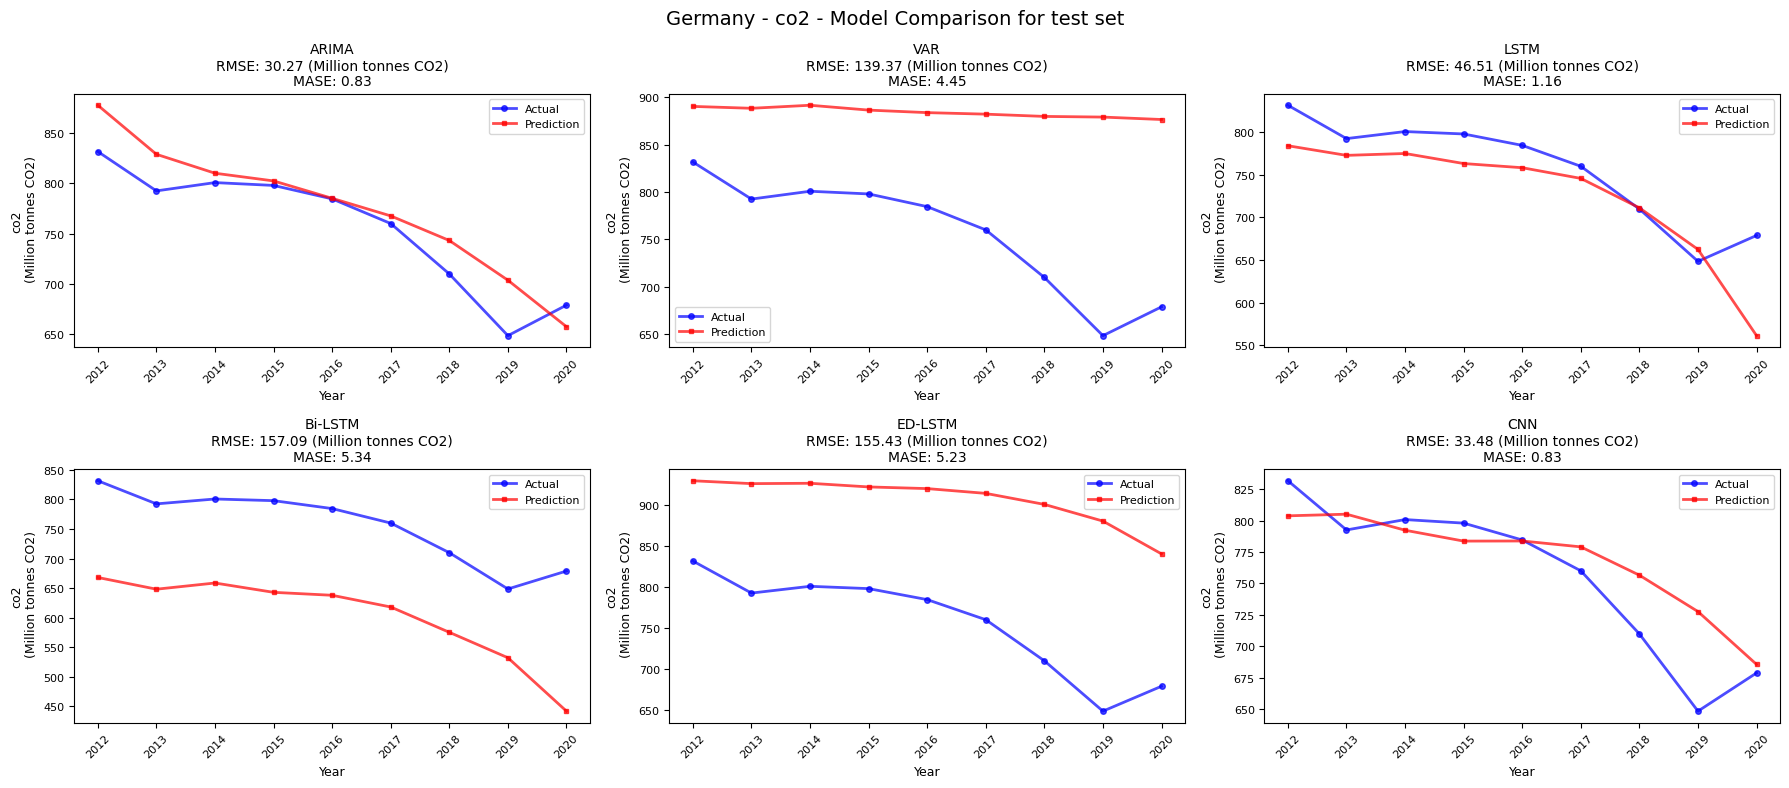

In [36]:
sample_countries = ['United States', 'China', 'Germany']
sample_targets = ['co2']

for target_var in sample_targets:
    if target_var in all_results:
        for country in sample_countries:
            if country in all_results[target_var] and all_results[target_var][country]:
                print(f"Plotting {country} - {target_var}")
                plot_model_comparisons(all_results, target_var, country)

Plotting United States - gdp
Plot saved: data_export\plots\United States_gdp_comparison.png


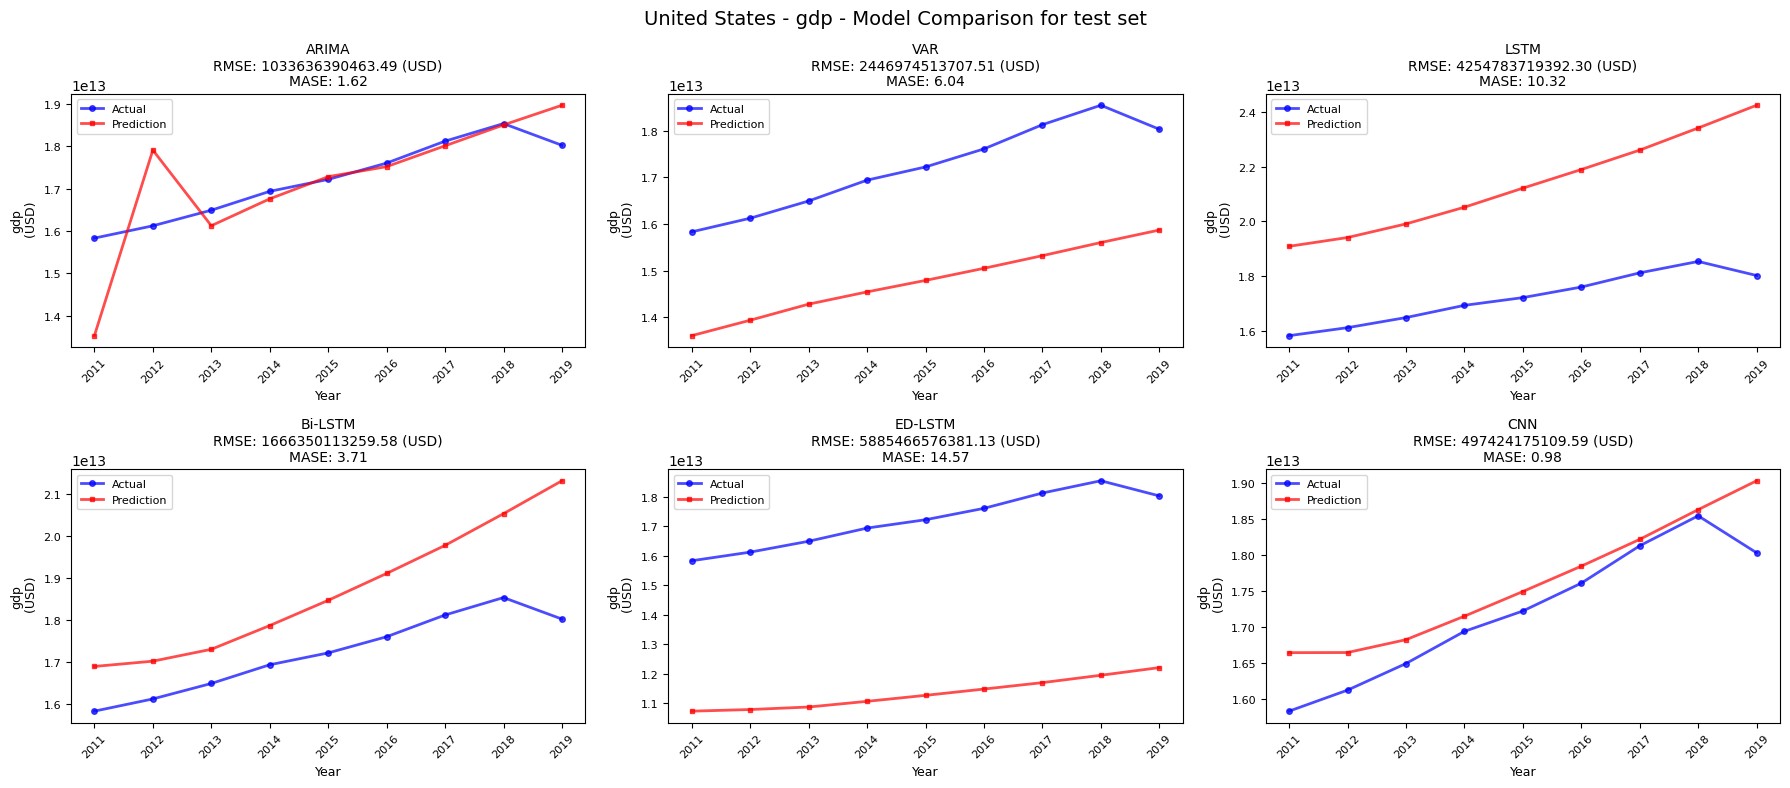

Plotting China - gdp
Plot saved: data_export\plots\China_gdp_comparison.png


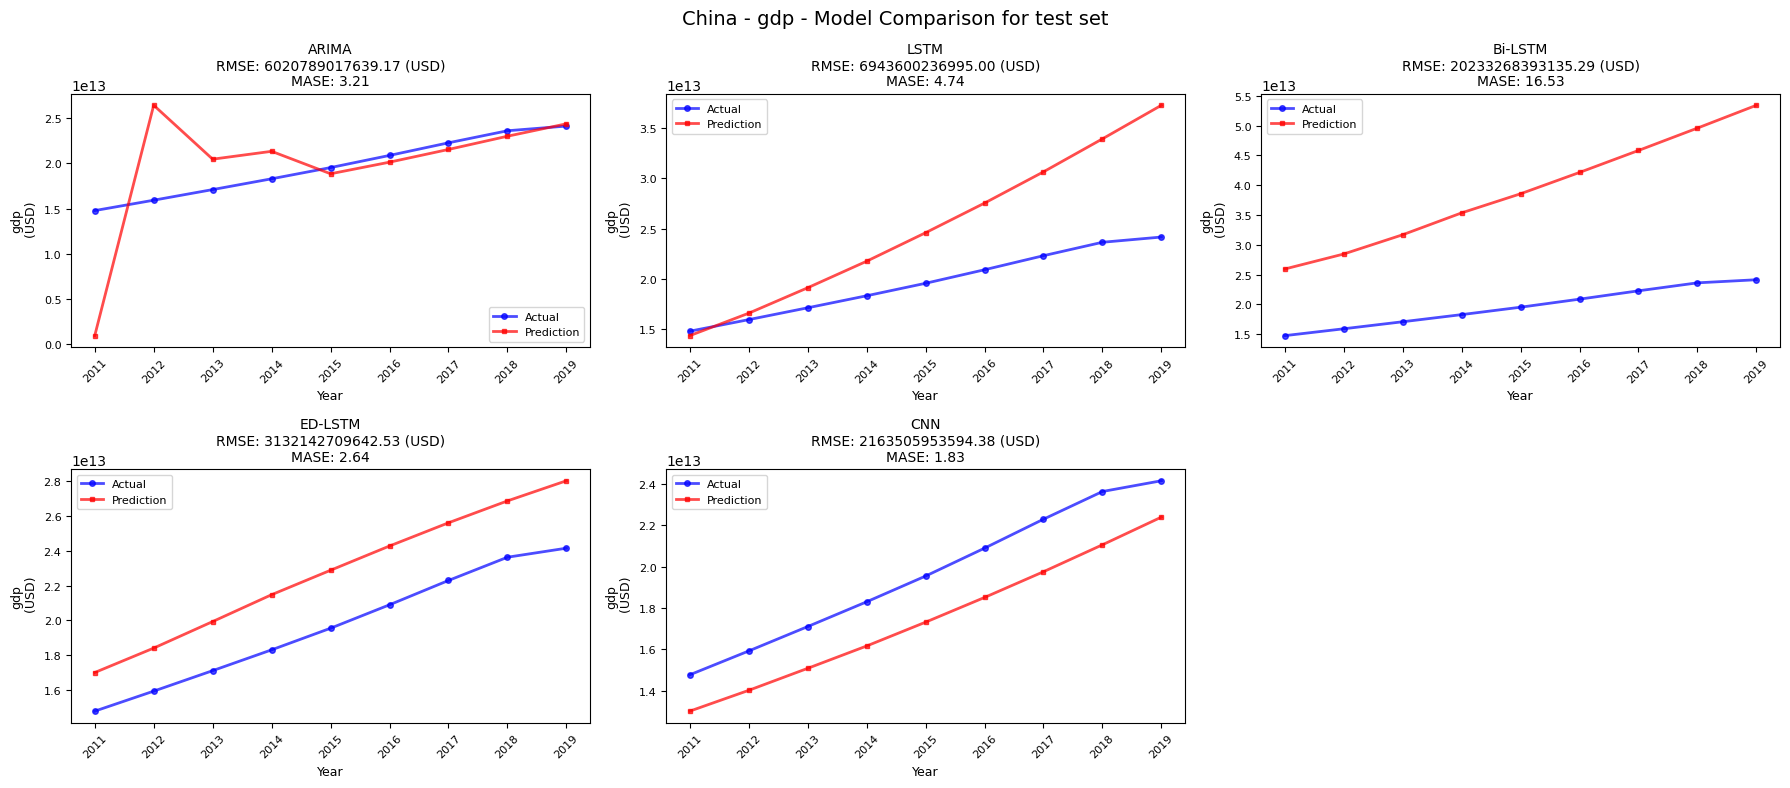

Plotting Australia - gdp
Plot saved: data_export\plots\Australia_gdp_comparison.png


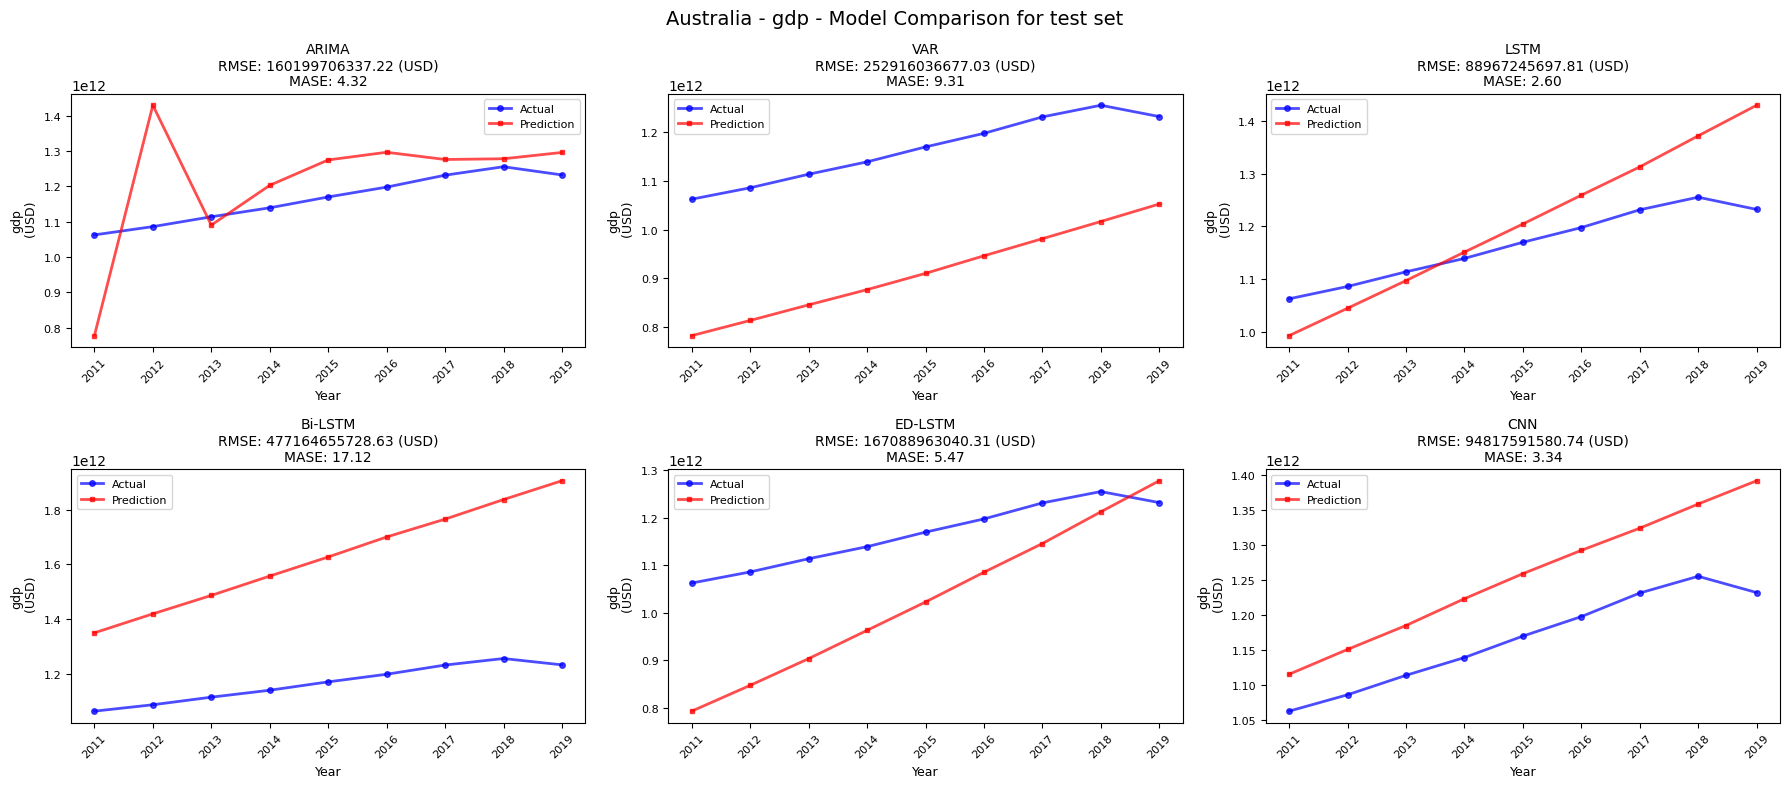

In [37]:
sample_countries = ['United States', 'China', 'Australia']
sample_targets = ['gdp']

for target_var in sample_targets:
    if target_var in all_results:
        for country in sample_countries:
            if country in all_results[target_var] and all_results[target_var][country]:
                print(f"Plotting {country} - {target_var}")
                plot_model_comparisons(all_results, target_var, country)

Plotting United States - primary_energy_consumption
Plot saved: data_export\plots\United States_primary_energy_consumption_comparison.png


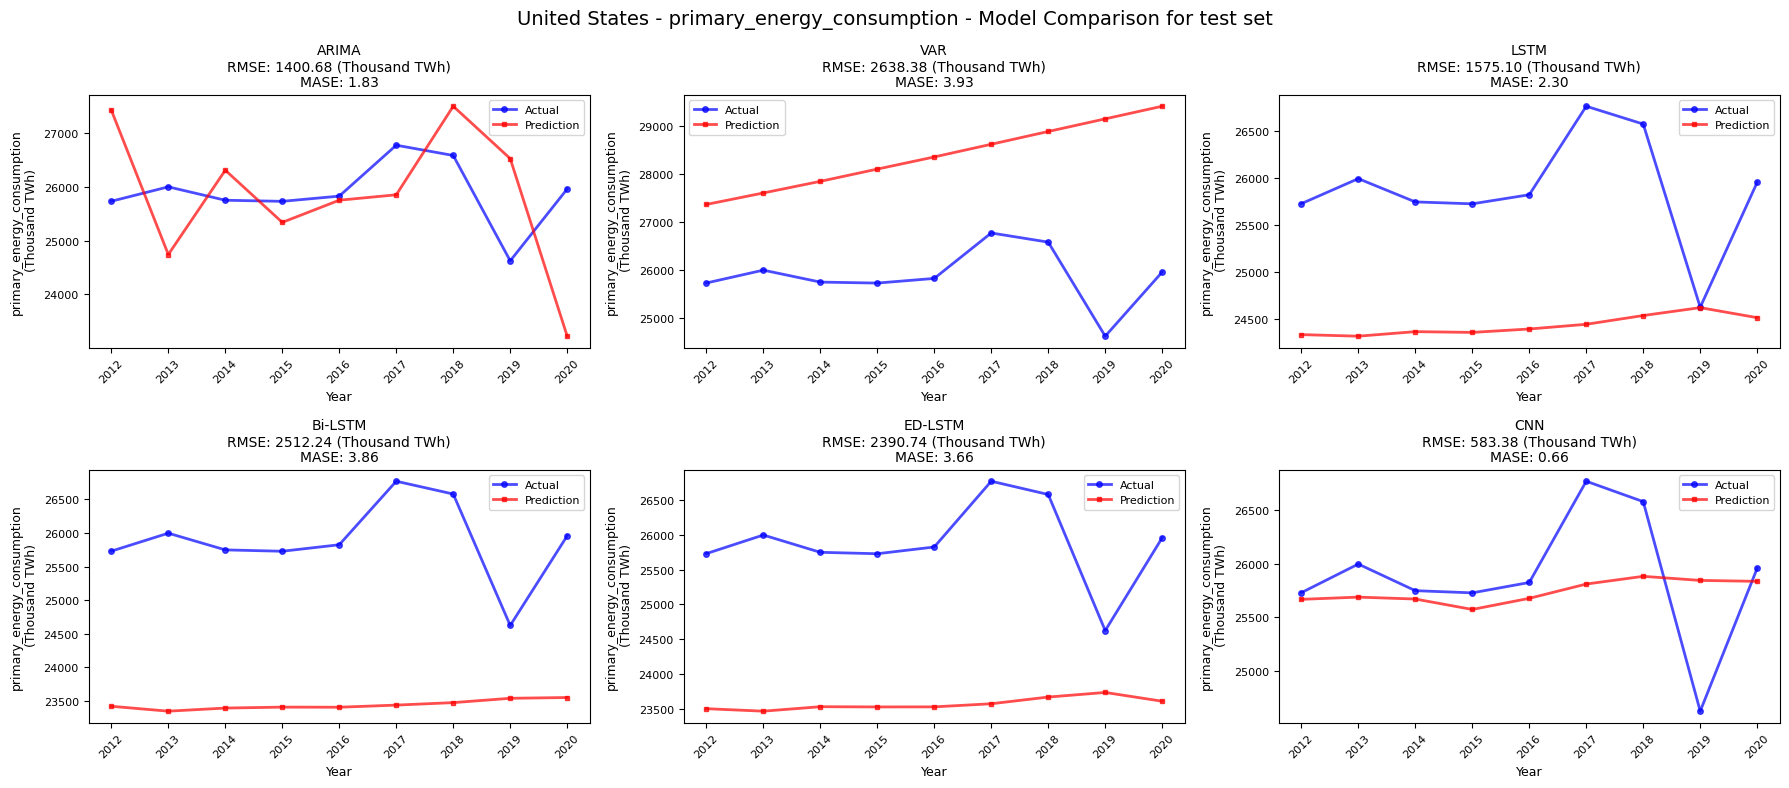

Plotting China - primary_energy_consumption
Plot saved: data_export\plots\China_primary_energy_consumption_comparison.png


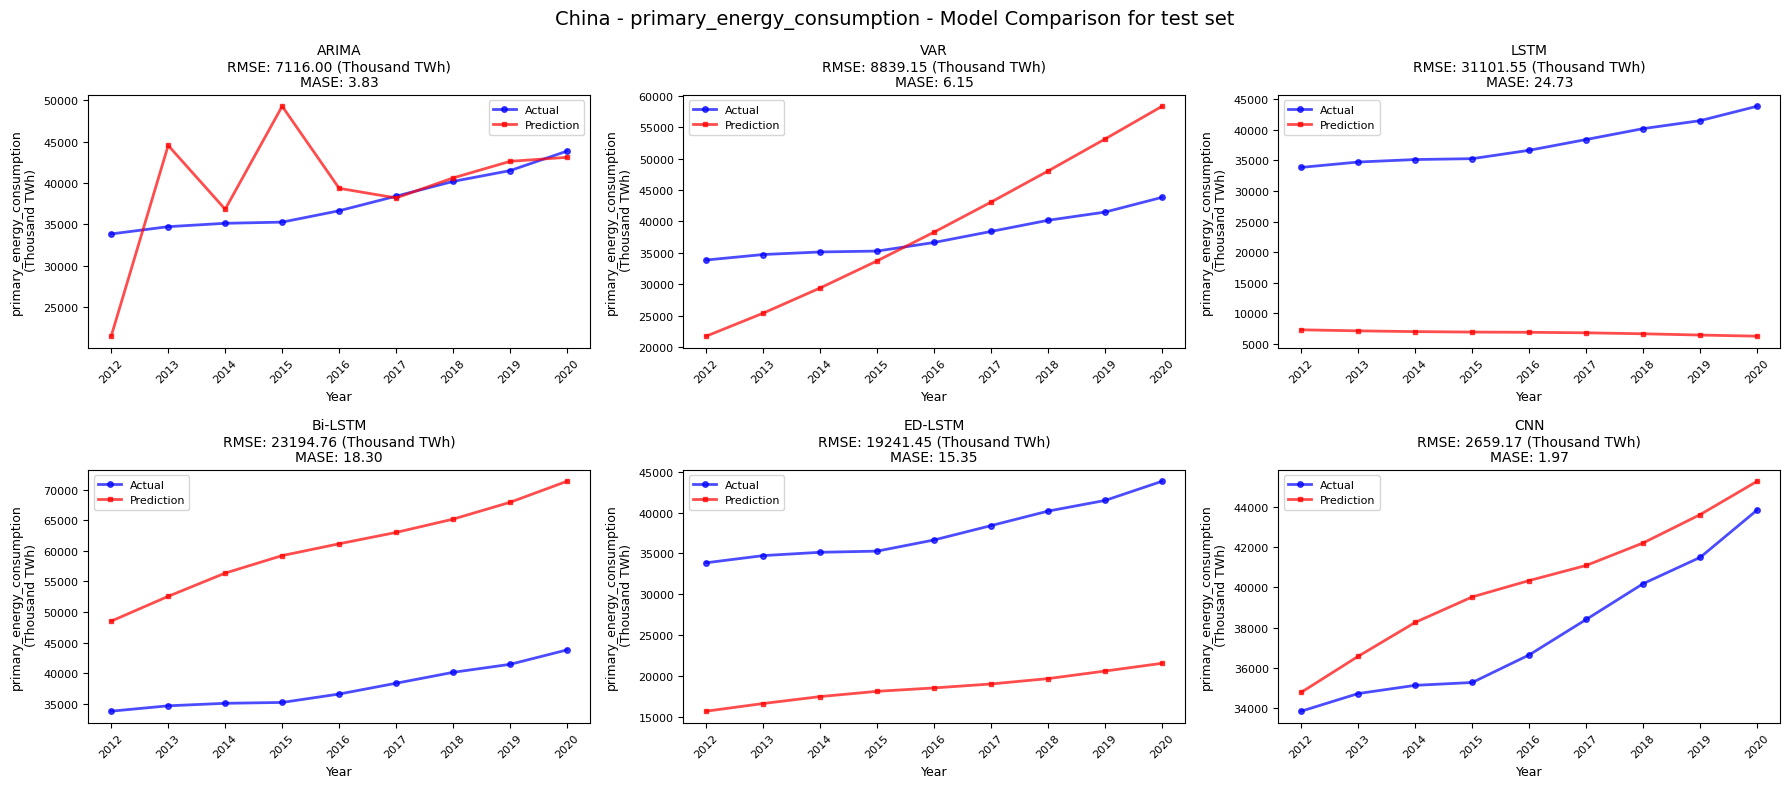

Plotting South Korea - primary_energy_consumption
Plot saved: data_export\plots\South Korea_primary_energy_consumption_comparison.png


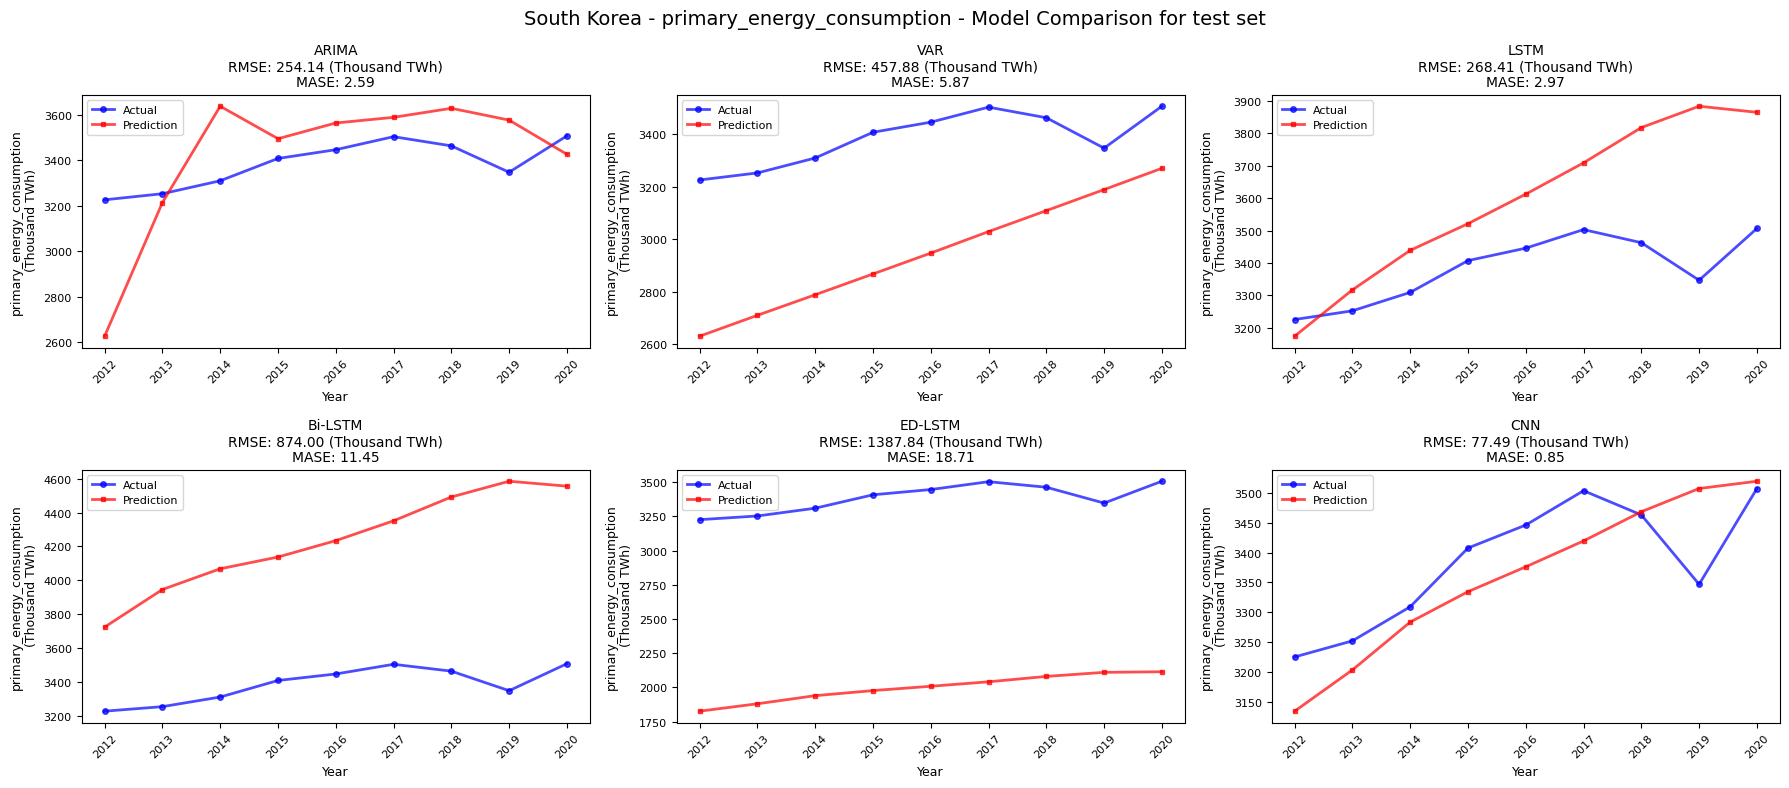

In [38]:
sample_countries = ['United States', 'China', 'South Korea']
sample_targets = ['primary_energy_consumption']

for target_var in sample_targets:
    if target_var in all_results:
        for country in sample_countries:
            if country in all_results[target_var] and all_results[target_var][country]:
                print(f"Plotting {country} - {target_var}")
                plot_model_comparisons(all_results, target_var, country)